In [32]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from prophet import Prophet

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

## Prophet Model on Time Series Data

Model takes roughly 10 minutes to run on the entire set of data!

**Goals of the notebook**:
1. Create a Prophet model that can handle 5 minute data
2. Understand how to evaluate the quality of the model, and visualize its performance
3. Understand how prophet works under the hood, and what sort of function is being used to represent our data.

In [26]:
raw_data = pd.read_csv("../data-files/CAISO_data.csv")
data = raw_data.drop("Unnamed: 0", axis=1)
data['timestamp'] = pd.to_datetime(data['timestamp']).dt.tz_convert('US/Pacific').dt.tz_localize(None)
data = data.rename({'timestamp': 'ds'}, axis=1)
data = data.rename({'load_MW': 'y'}, axis=1)
data = data[['ds', 'y']].sort_values('ds', ascending=True)
data.head()

,ds,y
171,2015-01-01 00:00:00,23041.0
55,2015-01-01 00:05:00,22937.0
77,2015-01-01 00:10:00,22824.0
132,2015-01-01 00:15:00,22707.0
111,2015-01-01 00:20:00,22596.0


# Model training

In [37]:
# The data are in order, so we can do an 80/20 split on a particular time

train_data = data.iloc[:int(0.8 * data.shape[0])]
test_data = data.iloc[int(0.8 * data.shape[0]):]

### Simple model, no tuning

This is what happens when we run prophet with no tuning steps.

In [41]:
my_model = Prophet()
my_model.fit(train_data)

21:21:44 - cmdstanpy - INFO - Chain [1] start processing
21:32:47 - cmdstanpy - INFO - Chain [1] done processing


In [43]:
prediction_obj = my_model.predict(test_data)

In [50]:
test_data.iloc[0]

ds    2021-05-26 07:05:00
y                23836.42
Name: 670754, dtype: object

In [79]:
prediction_obj.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'yearly', 'yearly_lower', 'yearly_upper',
       'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [82]:
prediction_obj['yhat']

0         21727.512797
1         21814.397205
2         21898.313833
3         21979.116251
4         22056.673706
              ...     
167647    19408.903143
167648    19260.864785
167649    19115.530093
167650    18972.970245
167651    18833.247042
Name: yhat, Length: 167652, dtype: float64

In [81]:
test_data

,ds,y
670754,2021-05-26 07:05:00,23836.42
670689,2021-05-26 07:10:00,23882.98
670641,2021-05-26 07:15:00,23877.29
670642,2021-05-26 07:20:00,23911.28
670806,2021-05-26 07:25:00,23922.86
...,...,...
838049,2022-12-31 23:35:00,20993.08
838194,2022-12-31 23:40:00,20941.46
838104,2022-12-31 23:45:00,20734.96
838105,2022-12-31 23:50:00,20673.72


## Model Evaluation

In [ ]:
# define some useful metrics

def rmse(preds, y):
    return np.sqrt(np.mean((preds - y)**2))

def mse(preds, y):
    return np.mean((preds - y)**2)

def mape(preds, y):
    return np.mean(np.abs(np.divide(preds - y, y, out=np.zeros_like(y), where=y!=0)))

In [83]:
mape(prediction_obj['yhat'].to_numpy(), test_data['y'].to_numpy())

0.08856276180016523

In [86]:
rmse(prediction_obj['yhat'].to_numpy(), test_data['y'].to_numpy())

2804.176487239049

(15000.0, 35000.0)

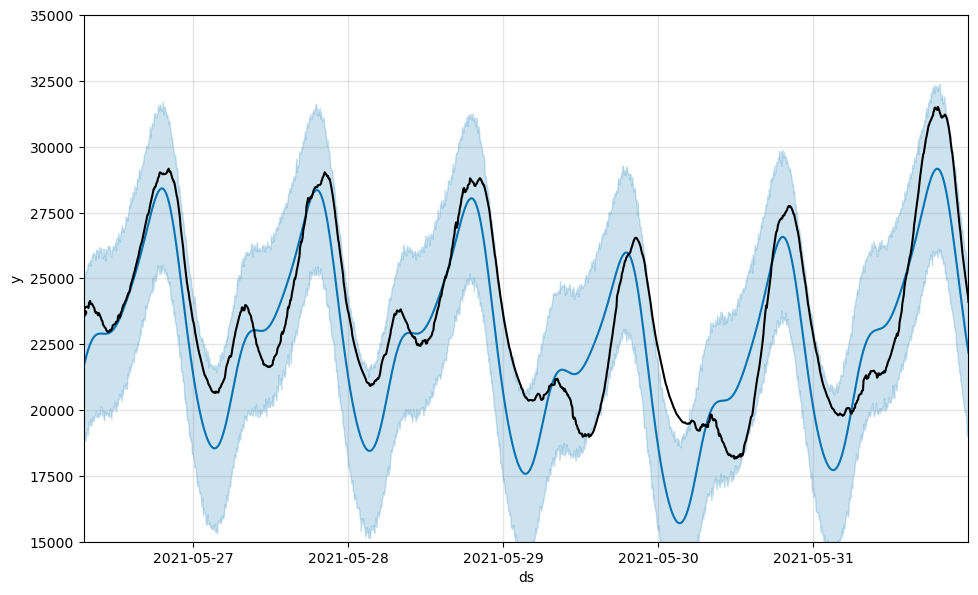

In [72]:
# plt.figure(figsize=(1, 200))
my_model.plot(prediction_obj)
plt.plot(test_data['ds'], test_data['y'], c='black')
plt.xlim(np.datetime64('2021-05-26 07:00'), np.datetime64('2021-05-31 23:59'))
plt.ylim(15000, 35000)

In [88]:
final_model = Prophet()
final_model.fit(data)

23:14:47 - cmdstanpy - INFO - Chain [1] start processing
23:28:22 - cmdstanpy - INFO - Chain [1] done processing


In [90]:
final_preds = final_model.predict(data)
final_preds.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 00:00:00,25292.841268,18777.454803,25493.762189,25292.841268,25292.841268,-3011.742434,-3011.742434,-3011.742434,-1902.961741,...,954.821918,954.821918,954.821918,-2063.602610,-2063.602610,-2063.602610,0.0,0.0,0.0,22281.098834
1,2015-01-01 00:05:00,25292.886223,18873.126422,25213.858788,25292.886223,25292.886223,-3139.683576,-3139.683576,-3139.683576,-2030.487351,...,954.558499,954.558499,954.558499,-2063.754725,-2063.754725,-2063.754725,0.0,0.0,0.0,22153.202646
2,2015-01-01 00:10:00,25292.931178,18540.406881,24983.422695,25292.931178,25292.931178,-3264.971275,-3264.971275,-3264.971275,-2155.349375,...,954.284847,954.284847,954.284847,-2063.906747,-2063.906747,-2063.906747,0.0,0.0,0.0,22027.959903
3,2015-01-01 00:15:00,25292.976132,18471.514143,25125.388316,25292.976132,25292.976132,-3387.577396,-3387.577396,-3387.577396,-2277.519716,...,954.000996,954.000996,954.000996,-2064.058676,-2064.058676,-2064.058676,0.0,0.0,0.0,21905.398736
4,2015-01-01 00:20:00,25293.021087,18231.104472,24604.527418,25293.021087,25293.021087,-3507.478378,-3507.478378,-3507.478378,-2396.974846,...,953.706979,953.706979,953.706979,-2064.210511,-2064.210511,-2064.210511,0.0,0.0,0.0,21785.542709


In [92]:
final_preds[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv("../predictions/prophet_preds.csv")